# Imports

In [1]:
# Standard library imports
import math
import os
import random
import time

# Third party imports
import descartes
import ghalton
from ipywidgets import interact, widgets, interactive
import matplotlib.pyplot as plt
from matplotlib import patches, collections
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
import numpy as np
import pandas as pd
import pyDOE
from scipy.spatial import Delaunay
import seaborn as sns
from shapely import geometry
from shapely.ops import cascaded_union, polygonize
import sklearn

# Local application imports
import nglpy_cuda as ngl
import samply


# Functions

In [2]:
def generate_sample_set(strategy, count, dimensionality, seed=0):
    np.random.seed(seed)

    if strategy == 'uniform':
        X = samply.hypercube.uniform(count, dimensionality)
    elif strategy == 'normal':
        X = samply.hypercube.normal(count, dimensionality)
    elif strategy == 'grid':
        X = samply.hypercube.grid(count, dimensionality)
    elif strategy == 'cvt':
        np.random.seed(seed)
        X = samply.hypercube.cvt(count, dimensionality)
    elif strategy == 'lhs':
        np.random.seed(seed)
        X = samply.hypercube.lhs(count, dimensionality)
    elif strategy == 'shell':
        X = samply.shape.shell(count, dimensionality)
    elif strategy == 'dshell':
        X = samply.shape.concentric_shells(count, dimensionality, gap_ratio=0.8)
    elif strategy == 'x':
        X = samply.shape.cross(count, dimensionality)
    elif strategy == 's':
        X = samply.shape.curve(count, dimensionality)
    elif strategy == 'stripes':
        X = samply.shape.stripes(count, dimensionality)
    elif strategy == 'distinct_mixture':
        means = [0.25*np.ones(dimensionality), 0.5*np.ones(dimensionality), 0.75*np.ones(dimensionality)]
        covs = [0.00125 * np.eye(dimensionality)]*3
        X = samply.hypercube.multimodal(count, dimensionality, means, covs)
    elif strategy == 'overlap_mixture':
        X = samply.hypercube.multimodal(count, dimensionality)
    elif strategy == 'halton':
        X = samply.hypercube.halton(count, dimensionality, seed)

    return X


In [3]:
def alpha_shape(points, alpha):
    """
    Compute the alpha shape (concave hull) of a set
    of points.
    @param points: Iterable container of points.
    @param alpha: alpha value to influence the
        gooeyness of the border. Smaller numbers
        don't fall inward as much as larger numbers.
        Too large, and you lose everything!
    """
    if len(points) < 4:
        # When you have a triangle, there is no sense
        # in computing an alpha shape.
        return geometry.MultiPoint(list(points)).convex_hull
    
    def add_edge(edges, edge_points, coords, i, j):
        """
        Add a line between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(coords[ [i, j] ])
        
    coords = np.array([point.coords[0] for point in points])
    tri = Delaunay(coords)
    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the
    # triangle
    for ia, ib, ic in tri.vertices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]
        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)
        # Semiperimeter of triangle
        s = (a + b + c)/2.0
        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))
        circum_r = a*b*c/(4.0*area)
        # Here's the radius filter.
        #print circum_r
        if circum_r < 1.0/alpha:
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)
    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
    return cascaded_union(triangles), edge_points

In [4]:
def out_of_bounds_count(G, X, alpha):
    obs = 0
    points = geometry.MultiPoint([ tuple(x) for x in X])
    concave_hull, edge_points = alpha_shape(points, alpha=alpha)
    for e1 in G.edges():
        line = geometry.LineString(X[e1, :])
        if not line.difference(line.intersection(concave_hull)).is_empty:
            obs += 1
    return obs

In [5]:
def average_area(G, X, alpha):
    # Somehow measure the emptiness of the alpha shape
    # Compute teh average area of the polygons cut out by the graph.
    # Smaller means better coverage
    points = geometry.MultiPoint([ tuple(x) for x in X])
    concave_hull, edge_points = alpha_shape(points, alpha=alpha)
    lines = []
    for e1 in G.edges():
        lines.append(geometry.LineString(X[e1, :]))

    polygons = polygonize(lines)
    areas = []
    for p in polygons:
        p = p.buffer(0)
        if p.difference(p.intersection(concave_hull)).is_empty:
            areas.append(p.area)
            
    if len(areas):
        return np.mean(areas)
    else:
        return concave_hull.area

In [6]:
def coverage(G, X, alpha):
    # Somehow measure the emptiness of the alpha shape
    # Compute teh average area of the polygons cut out by the graph.
    # Smaller means better coverage
    points = geometry.MultiPoint([ tuple(x) for x in X])
    concave_hull, edge_points = alpha_shape(points, alpha=alpha)
    lines = []
    for e1 in G.edges():
        lines.append(geometry.LineString(X[e1, :]))

    polygons =  []
    for p in polygonize(lines):
        p = p.buffer(0)
        if p.difference(p.intersection(concave_hull)).is_empty:
            polygons.append(p)
            
    polytope = cascaded_union(polygons)
    return polytope.area / concave_hull.area

In [7]:
def intersect(a1, b1, a2, b2):
    """Returns True if line segments a1b1 and a2b2 intersect."""
    return ccw(a1, b1, a2) != ccw(a1, b1, b2) and ccw(a2, b2, a1) != ccw(a2, b2, b1)

def ccw(A, B, C):
    """Tests whether the turn formed by A, B, and C is ccw"""
    return (B[0] - A[0]) * (C[1] - A[1]) > (B[1] - A[1]) * (C[0] - A[0])

In [8]:
def crossing_count(G):
    crossings = 0
    edges = list(G.edges())
    for i, e1 in enumerate(edges):
        pts1 = X[e1, :]
        for e2 in edges[(i+1):]:
            if e2[0] in e1 or e2[1] in e1:
                continue
            pts2 = X[e2, :]
            if intersect(pts1[0], pts1[1], pts2[0], pts2[1]):
                crossings += 1
    return crossings

In [9]:

# def handle_event_point(p):
#     pass

# def find_intersections(X, G):
#     segments = [(X[e[0]], X[e[1]]) for e in G.edges()]
#     queue = []
#     for seg in segments:
#         if seg[1][0] < seg[0][0]:
#             lo = 1
#             hi = 0
#         else:
#             lo = 0
#             hi = 1
#         heapq.heappush(heap, (seg[lo][0], seg))
#         heapq.heappush(heap, (seg[hi][0], None))

#     while len(heap):
#         (x, seg) = heapq.heappop(heap)
#         handle_event_point(x)

# Test the Samplers

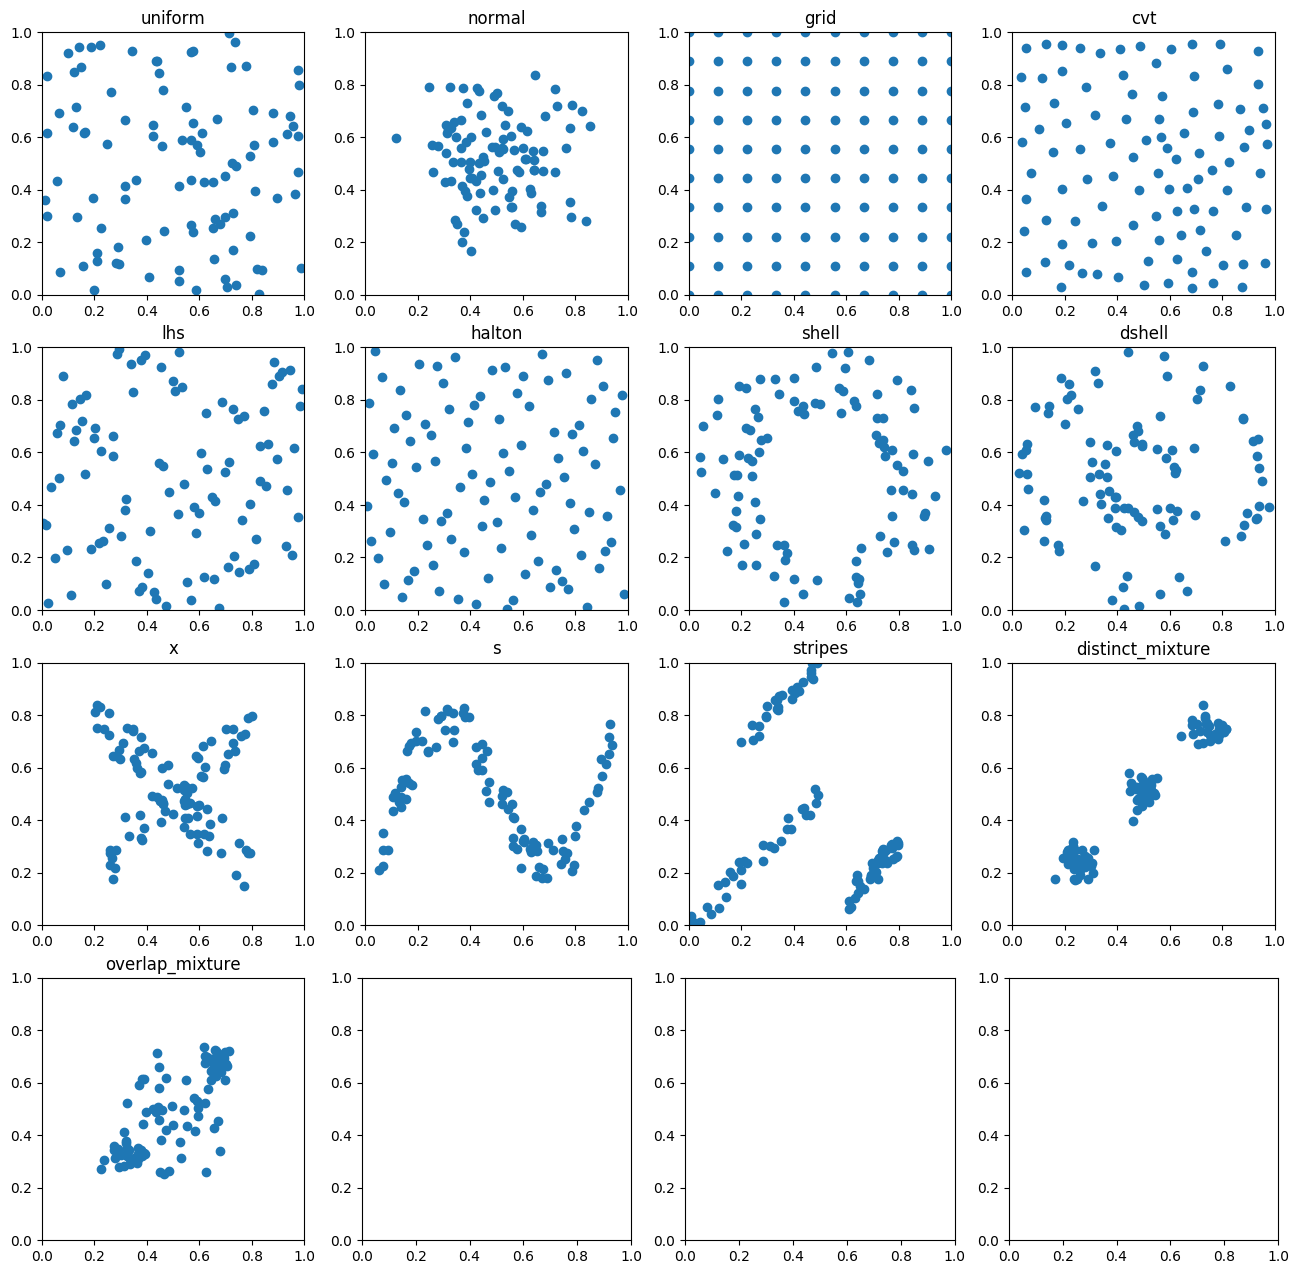

In [10]:
%matplotlib inline

count = 100
dimensionality = 2
strategies = ["uniform", "normal", "grid", "cvt", "lhs", "halton", "shell",
              "dshell", "x", "s", "stripes", "distinct_mixture",
              "overlap_mixture"]

plot_dim = int(np.ceil(np.sqrt(len(strategies))))
fig, axes = plt.subplots(nrows=plot_dim, ncols=plot_dim, dpi=100, figsize=(4*plot_dim, 4*plot_dim))

for ax,strategy in zip(axes.flatten(), strategies):
    X = generate_sample_set(strategy, count, dimensionality)
    ax.scatter(X[:,0], X[:,1])
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_aspect(1)
    ax.set_title(strategy)

# Sample the $\beta_p$-Skeletons

In [11]:
@interact(strategy=strategies)
def sample_betas(strategy):
    count = 100
    dimensionality = 2

    X = generate_sample_set(strategy, count, dimensionality)
    graphs = {}
#     betas = np.arange(0.25, 2.25,0.25)
#     ps = [0.2, 0.4, 0.8, 1, 2, 4]
    betas = [0.25, 0.5, 1, 1.5, 2]
    ps = [0.4, 0.8, 1, 2, 4]

    fig, axes = plt.subplots(nrows=len(betas), ncols=len(ps), dpi=200, figsize=(2*len(ps), 2*len(betas)))

    for row, beta in enumerate(betas):
        for col, p in enumerate(ps):
            ax = axes[row, col]
            go = ngl.EmptyRegionGraph(beta=beta, p=p, relaxed=False)
            go.build(X)
            lines = []
            G = nx.Graph()
            for i in range(count):
                G.add_node(i)
            for (a, b, distance) in go:
                G.add_edge(a, b, length=distance)
                lines.append([(X[a,0], X[a,1]), (X[b, 0], X[b, 1])])

            graphs[(beta, p)] = G
            line_segments = collections.LineCollection(lines, colors='#a6cee3', alpha=0.5, linestyles='--', zorder=2)

            ax.scatter(X[:,0], X[:,1], marker=',', s=1, zorder=3)
            ax.add_collection(line_segments)
            ax.set_xlim(0,1)
            ax.set_ylim(0,1)
            ax.set_aspect(1)
            if row == 0:
                ax.set_title("p: {}".format(p))
            if row != len(betas)-1:
                ax.set_xticks([])
            if col == 0:
                ax.set_ylabel("beta: {:0.2f}".format(beta))
            else:
                ax.set_yticks([])

interactive(children=(Dropdown(description='strategy', options=('uniform', 'normal', 'grid', 'cvt', 'lhs', 'ha…

# Sample KNN Graphs

In [12]:
@interact(strategy=strategies)
def sample_knns(strategy):
    count = 100
    dimensionality = 2

    X = generate_sample_set(strategy, count, dimensionality)

    k_graphs = {}
    ks = range(1,26)
    plot_dim = int(np.ceil(np.sqrt(len(ks))))
    fig, axes = plt.subplots(nrows=plot_dim, ncols=plot_dim, dpi=100, figsize=(2*plot_dim, 2*plot_dim))
    for k, ax in zip(ks, axes.flatten()):
        go = ngl.DistanceGraph(max_neighbors=k+1)
        go.build(X)
        lines = []
        G = nx.Graph()
        for i in range(count):
            G.add_node(i)
        for (a, b, distance) in go:
            G.add_edge(a, b, length=distance)
            lines.append([(X[a,0], X[a,1]), (X[b, 0], X[b, 1])])

        line_segments = collections.LineCollection(lines, colors='#a6cee3', alpha=0.5, linestyles='--', zorder=2)
        ax.scatter(X[:,0], X[:,1], marker=',', s=1, zorder=3)
        ax.add_collection(line_segments)
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect(1)
        ax.set_title("k: {}".format(k))

        k_graphs[k] = G
    

interactive(children=(Dropdown(description='strategy', options=('uniform', 'normal', 'grid', 'cvt', 'lhs', 'ha…

# Sample Yao Graphs

In [13]:
@interact(strategy=strategies)
def sample_yaos(strategy):
    count = 100
    dimensionality = 2

    X = generate_sample_set(strategy, count, dimensionality)

    cones = list(range(1,6))
    points = list(range(1,4))
    fig, axes = plt.subplots(nrows=len(cones), ncols=len(points), dpi=100, figsize=(2*len(points), 2*len(cones)))
    yao_graphs = {}
    for row, k in enumerate(cones):
        for col, n in enumerate(points):
            ax = axes[row, col]
            go = ngl.ConeGraph(num_sectors=k, points_per_sector=n, algorithm="yao")
            go.build(X)
            lines = []
            G = nx.Graph()
            for i in range(count):
                G.add_node(i)
            for (a, b, distance) in go:
                G.add_edge(a, b, length=distance)
                lines.append([(X[a,0], X[a,1]), (X[b, 0], X[b, 1])])

            line_segments = collections.LineCollection(lines, colors='#a6cee3', alpha=0.5, linestyles='--', zorder=2)

            ax.scatter(X[:,0], X[:,1], marker=',', s=1, zorder=3)
            ax.add_collection(line_segments)
            ax.set_xlim(0,1)
            ax.set_ylim(0,1)
            ax.set_aspect(1)
            if row == 0:
                ax.set_title("n: {}".format(n))
            if row != len(cones)-1:
                ax.set_xticks([])
            if col == 0:
                ax.set_ylabel("k: {}".format(k))
            else:
                ax.set_yticks([])

            yao_graphs[k] = G

interactive(children=(Dropdown(description='strategy', options=('uniform', 'normal', 'grid', 'cvt', 'lhs', 'ha…

# $\Theta$ Graphs

In [14]:
@interact(strategy=strategies)
def sample_thetas(strategy):
    count = 100
    dimensionality = 2

    X = generate_sample_set(strategy, count, dimensionality)

    cones = list(range(1,6))
    points = list(range(1,4))
    fig, axes = plt.subplots(nrows=len(cones), ncols=len(points), dpi=100, figsize=(2*len(points), 2*len(cones)))
    theta_graphs = {}
    for row, k in enumerate(cones):
        for col, n in enumerate(points):
            ax = axes[row, col]
            go = ngl.ConeGraph(num_sectors=k, points_per_sector=n, algorithm="theta")
            go.build(X)
            lines = []
            G = nx.Graph()
            for i in range(count):
                G.add_node(i)
            for (a, b, distance) in go:
                G.add_edge(a, b, length=distance)
                lines.append([(X[a,0], X[a,1]), (X[b, 0], X[b, 1])])

            line_segments = collections.LineCollection(lines, colors='#a6cee3', alpha=0.5, linestyles='--', zorder=2)

            ax.scatter(X[:,0], X[:,1], marker=',', s=1, zorder=3)
            ax.add_collection(line_segments)
            ax.set_xlim(0,1)
            ax.set_ylim(0,1)
            ax.set_aspect(1)
            if row == 0:
                ax.set_title("n: {}".format(n))
            if row != len(cones)-1:
                ax.set_xticks([])
            if col == 0:
                ax.set_ylabel("k: {}".format(k))
            else:
                ax.set_yticks([])

            theta_graphs[k] = G

interactive(children=(Dropdown(description='strategy', options=('uniform', 'normal', 'grid', 'cvt', 'lhs', 'ha…

# Demonstration  of Techniques

The edge crossing algorithm needs optimized, here we are just picking a dense graph in order to test how long it takes.

In [15]:
go = ngl.EmptyRegionGraph(beta=0.2, p=0.2, relaxed=False)
go.build(X)
lines = []
G = nx.Graph()
for i in range(count):
    G.add_node(i)
edge_count = 0
for (a, b, distance) in go:
    G.add_edge(a, b, length=distance)
    edge_count += 1
print(1, 2, crossing_count(G), edge_count)

1 2 34823 4876



The idea is to come up with some metrics that tell us how good a graph is at capturing the shape of a dataset without overcomplicating things. The following figures demonstrate what I mean on the "S" shaped data:

In [16]:
def draw_hull(strategy, alpha, go):
    count = 100
    dimensionality = 2

    X = generate_sample_set(strategy, count, dimensionality)
    go.build(X)
    G = nx.Graph()
    for i in range(count):
        G.add_node(i)
    for (a, b, distance) in go:
        G.add_edge(a, b, length=distance)
    
    points = geometry.MultiPoint([ tuple(x) for x in X])
    concave_hull, edge_points = alpha_shape(points, alpha=alpha)
    lines = []
    fig, ax = plt.subplots(nrows=2, ncols=2, dpi=100, figsize=(4,4))
    for e1 in G.edges():
        lines.append(geometry.LineString(X[e1, :]))
        ax[0,0].plot(*np.array(lines[-1]).T, c="k")
    ax[0,0].set_aspect(1)
    ax[0,0].set_xlim(0,1)
    ax[0,0].set_ylim(0,1)

    ax[1,0].add_patch(descartes.PolygonPatch(concave_hull))
    ax[1,0].set_aspect(1)
    ax[1,0].set_xlim(0,1)
    ax[1,0].set_ylim(0,1)
    
    polygons = []
    for p in polygonize(lines):
        p = p.buffer(0)
        intersection = p.intersection(concave_hull)
        diff = p.difference(intersection)
        if diff.is_empty:
            polygons.append(p)
            ax[0,1].add_patch(descartes.PolygonPatch(p))
    ax[0,1].set_aspect(1)
    ax[0,1].set_xlim(0,1)
    ax[0,1].set_ylim(0,1)
    
    polytope = cascaded_union(polygons)
    ax[1,1].add_patch(descartes.PolygonPatch(polytope))
    ax[1,1].set_aspect(1)
    ax[1,1].set_xlim(0,1)
    ax[1,1].set_ylim(0,1)

def draw_hull_beta(strategy, alpha, beta, p):
    go = ngl.EmptyRegionGraph(beta=0.8, p=2.0, relaxed=False)
    draw_hull(strategy, alpha, go)

def draw_hull_knn(strategy, alpha, k):
    go = ngl.DistanceGraph(max_neighbors=k)
    draw_hull(strategy, alpha, go)
    
def draw_hull_yao(strategy, alpha, k, n):
    go = ngl.ConeGraph(num_sectors=k, points_per_sector=n, algorithm="yao")
    draw_hull(strategy, alpha, go)
    
beta_widget = interactive(draw_hull_beta, strategy=strategies,
                          alpha=widgets.FloatSlider(min=0.2, max=20, step=0.2, continuous_update=False),
                          beta=widgets.FloatSlider(min=0.2, max=2, step=0.2, continuous_update=False),
                          p=widgets.FloatSlider(min=0.2, max=4, step=0.2, continuous_update=False))

knn_widget = interactive(draw_hull_knn, strategy=strategies,
                          alpha=widgets.FloatSlider(min=0.2, max=20, step=0.2, continuous_update=False),
                          k=widgets.IntSlider(min=1, max=20, step=1, continuous_update=False))

yao_widget = interactive(draw_hull_yao, strategy=strategies,
                          alpha=widgets.FloatSlider(min=0.2, max=20, step=0.2, continuous_update=False),
                          k=widgets.IntSlider(min=1, max=20, step=1, continuous_update=False),
                          n=widgets.IntSlider(min=1, max=10, step=0.2, continuous_update=False))


In [17]:
display(beta_widget)

interactive(children=(Dropdown(description='strategy', options=('uniform', 'normal', 'grid', 'cvt', 'lhs', 'ha…

interactive(children=(Dropdown(description='strategy', options=('uniform', 'normal', 'grid', 'cvt', 'lhs', 'ha…

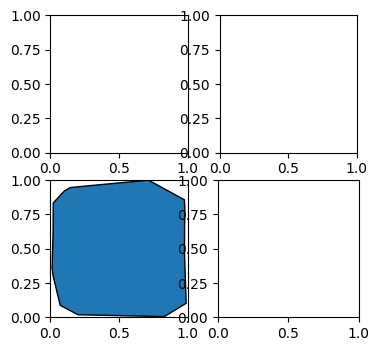

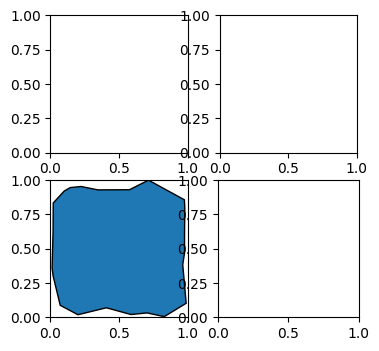

In [18]:
display(knn_widget)

interactive(children=(Dropdown(description='strategy', options=('uniform', 'normal', 'grid', 'cvt', 'lhs', 'ha…

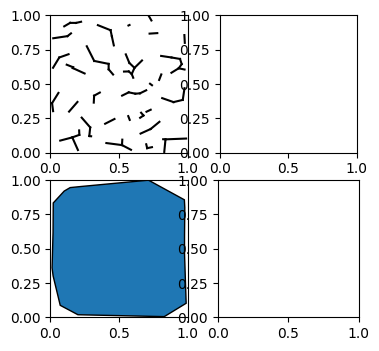

In [19]:
display(yao_widget)

The first shows a "messy" graph. Without doing much, we can hopefully agree that intersecting lines are bad. This leads to our first metric. A good graph should minimize or eliminate all intersections, since they can lead to things like crossing integral lines when applying topological analysis. Alternatively, very sparse graphs can tend to miss undulates or features in the data. What we want is a graph that does not have intersections, but in some sense "fills" the space as much as possible. Let's come back to this in a bit.

There is some inherent shape that we can capture by looking at the "correct" alpha shape of the dataset (second image). Mind you, this takes some tuning to understand for even 2D cases. Higher dimensions will be even more of a problem, but let's start with 2D and see if anything can generalize. The third image shows the edges of the "messy" graph that travel only through the alpha shape. We can use this to devise two metrics: first, we can count the number of edges that go outside the alpha shape and somehow violate the "shape" of the data. We want to minimize this count; and the second is to see evaluate how well a polygonization of the edges fills the alpha shape. The union of these polygons is shown in the last image and does a fairly decent job of replicating the alpha shape. We will call this last metric "coverage" since it tells us how much of the alpha shape is covered. Alternatively, we could thing of these two metrics as a version of precision and recall, respectively.

Lastly, let us return to our notion of filling the empty regions of the space. Looking again at the third image, we see a large polygon carved out by the edges in the upward hump of the "S," and we also see another one of these large polygons in the lower hump of the "S." These large polygons are not desirable, as we are missing data for anything that happens in the interior of this region. We have to rely on interpolation, and the farther the endpoints are from the center of the polygon, we can assume the interpolation only becomes less reliable. So, in order to favor smaller polygons, we devise a metric that yields the average area of the polygons induced by the sub-graph that lies within the alpha hull. This last part is debatable, because we don't care what happens outside the alpha shape since we are relying on other metrics to reduce the existence of those features, but one could argue that these edges will tend to induce larger polygons thus further penalizing graphs we know to be bad. So, we could relax this metric to be over all polygons induced by the graph.

For these metrics to generalize to higher dimensions (let's say the modest case of up to 5D for now), we need:
 * Alpha shapes for high dimensions (CGAL?)
 * A way to find the "correct" alpha value for different shapes in all dimensions
 * A way to compute high dimensional volumes (Monte Carlo sampling?)
 * An algorithm for finding line segment intersection or approximate intersection in high dimensions (closest points on Fattened rods?)
 * An algorithm for inducing polytopes on a 1-skeleton graph (I have no clue...)

# Applying Metrics to the $\beta_p$-Skeletons and KNN Graphs

## Compute Metrics for $\beta_p$-Skeletons

In [ ]:
betas = []
ps = []
crossings = []
out_of_bounds = []
average_areas = []
coverages = []
for (beta, p), G in graphs.items():
    betas.append(beta)
    ps.append(p)
    out_of_bounds.append(out_of_bounds_count(G, X, 8))
    average_areas.append(average_area(G, X, 8))
    coverages.append(coverage(G, X, 8))
    crossings.append(crossing_count(G))

In [ ]:
beta_skeleton_df = pd.DataFrame({"beta": np.round(betas, 1),
                                 "p": ps,
                                 "crossed_count": crossings,
                                 "out_of_bounds_count": out_of_bounds,
                                 "average_area": average_areas,
                                 "coverage": coverages})
beta_skeleton_df.describe()

In [ ]:
x = beta_skeleton_df["beta"]
y = beta_skeleton_df["p"]

metrics = ["crossed_count", "out_of_bounds_count", "average_area", "coverage"]
high_is_bad = ["crossed_count", "average_area", "out_of_bounds_count"]

f, ax = plt.subplots(2,2, sharex=True, sharey=True, dpi=400, squeeze=True)
for a, m in zip(ax.flatten(), metrics):
    z = np.clip(beta_skeleton_df[m], 0, 100)
    if m not in high_is_bad:
        z = np.max(z)-z
    a.tricontourf(x,y,z, cmap="Reds")
    a.plot(x,y, 'ko ')
    a.plot(1,2, 'wo ', markersize=5)
    a.set_aspect(.25)
    a.set_title(m)
    
ax[0,0].set_ylabel = "p"
ax[1,0].set_ylabel = "p"
ax[1,0].set_xlabel = r"$\beta$"
ax[1,1].set_xlabel = r"$\beta$"

In [ ]:
metrics = ["crossed_count", "out_of_bounds_count", "average_area", "coverage"]
titles  = ["Minimizing Crossings",
           "Minimizing Edges Lying Outside the Alpha Hull",
           "Minimizing The Average Area of the Induced Polygons",
           "Maximizing Coverage of the Alpha Hull"]
for metric, title in zip(metrics, titles):
    plt.figure()
    sns.lineplot(data=beta_skeleton_df, x="beta", hue="p", y=metric, legend="full")
    ax = plt.gca()
    ax.set_title(title)
    if title.startswith("Min"):
        optimal_index = np.argmin(beta_skeleton_df[metric])
    else:
        optimal_index = np.argmax(beta_skeleton_df[metric])
    
    optimal_x = beta_skeleton_df["beta"][optimal_index]
    optimal_y = beta_skeleton_df[metric][optimal_index]
    ax.axvline(optimal_x, 0, ax.get_ylim()[1], linestyle="dashed")

In [ ]:
for metric, title in zip(metrics, titles):
    plt.figure()
    sns.lineplot(data=beta_skeleton_df, x="p", hue="beta", y=metric, legend="full")
    ax = plt.gca()
    ax.set_title(title)
    if title.startswith("Min"):
        optimal_index = np.argmin(beta_skeleton_df[metric])
    else:
        optimal_index = np.argmax(beta_skeleton_df[metric])
    
    optimal_x = beta_skeleton_df["beta"][optimal_index]
    optimal_y = beta_skeleton_df[metric][optimal_index]
    ax.axvline(optimal_x, 0, ax.get_ylim()[1], linestyle="dashed")


# Compute Metrics for KNN Graphs

In [ ]:
ks = []
crossings = []
out_of_bounds = []
average_areas = []
coverages = []
for k, G in k_graphs.items():
    ks.append(k)
    out_of_bounds.append(out_of_bounds_count(G, X, 8))
    average_areas.append(average_area(G, X, 8))
    coverages.append(coverage(G, X, 8))
    crossings.append(crossing_count(G))

In [ ]:
knn_df = pd.DataFrame({"k": ks,
                       "crossed_count": crossings,
                       "out_of_bounds_count": out_of_bounds,
                       "average_area": average_areas,
                       "coverage": coverages})
knn_df.describe()

In [ ]:
plt.figure()
sns.lineplot(data=knn_df, x="k", y="crossed_count", legend="full")
plt.gca().set_title("Minimizing Crossings")

plt.figure()
sns.lineplot(data=knn_df, x="k", y="out_of_bounds_count", legend="full")
plt.gca().set_title("Minimizing Edges Lying Outside the Alpha Hull")

plt.figure()
sns.lineplot(data=knn_df, x="k", y="average_area", legend="full")
plt.gca().set_title("Minimizing The Average Area of the Induced Polygons")

plt.figure()
sns.lineplot(data=knn_df, x="k", y="coverage", legend="full")
_ = plt.gca().set_title("Maximizing Coverage of the Alpha Hull")

# Delaunay Analysis

Here we see how even the Delaunay triangulation (unconstrained) can give some counterproductive results:

In [ ]:
triangles = Delaunay(X).simplices
G = nx.Graph()
for i in range(len(X)):
    G.add_node(i)

lines = []
for tri in triangles:
    lines.append([(X[tri[0],0], X[tri[0],1]), (X[tri[1], 0], X[tri[1], 1])])
    lines.append([(X[tri[0],0], X[tri[0],1]), (X[tri[2], 0], X[tri[2], 1])])
    lines.append([(X[tri[1],0], X[tri[1],1]), (X[tri[2], 0], X[tri[2], 1])])
    G.add_edge(tri[0], tri[1])
    G.add_edge(tri[0], tri[2])
    G.add_edge(tri[1], tri[2])

line_segments = collections.LineCollection(lines, colors='#a6cee3', alpha=0.5, linestyles='--', zorder=2)
fig = plt.figure()
ax = plt.gca()
ax.scatter(X[:,0], X[:,1], marker=',', s=1, zorder=3)
ax.add_collection(line_segments)

print("Delaunay:\n\t               Crossing Count: {}\n\t     Out of Bounds Edge Count: {}\n\t Average Induced Polygon Area: {:.3e}\n\t               Alpha Coverage: {}".format(crossing_count(G),
                                        out_of_bounds_count(G, X, 8),
                                        average_area(G, X, 8),
                                        coverage(G, X, 8)))

# Notes

* Use total length of out of bounds segments for metric
* Compute a continuous set of $\alpha$ values and plot number of connected components and total area to use as a kind of persistence chart, so we can determine the "correct" $\alpha$ for each dataset
* Minimum, Average, Maximum, Variance of edge lengths
* Minimum, Maximum, Avergge, & Variance of Connectivity

# Look at some Graph Metrics from Networkx

These are metrics on abstract graphs, we have geometric graphs, so I am unsure these tell us anything useful. Leaving in for posterity, but should probabyl be removed at some point knowing git will track its existence.

In [ ]:
# for (beta, p), G in graphs.items():
#     k_components = nx.k_components(G)
#     for key, value in k_components.items():
#         component_sizes = list(map(len, value))
#         print(beta, p, key, min(component_sizes), max(component_sizes))

In [ ]:
# %matplotlib notebook

# triples = []
# for (beta, p), G in graphs.items():
#     triples.append((beta, p, len(nx.algorithms.approximation.clique.max_clique(G))))
# vals = np.array(triples)

# fig = plt.figure(dpi=100)
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_trisurf(vals[:, 0], vals[:, 1], vals[:, 2])
# plt.gca().set_xlabel("beta")
# plt.gca().set_ylabel("p")
# _ = plt.gca().set_zlabel("Maximum Clique Size")

In [ ]:
# %matplotlib notebook

# triples = []
# for (beta, p), G in graphs.items():
#     triples.append((beta, p, nx.algorithms.approximation.clustering_coefficient.average_clustering(G, trials=10000)))
# vals = np.array(triples)

# fig = plt.figure(dpi=100)
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_trisurf(vals[:, 0], vals[:, 1], vals[:, 2])
# plt.gca().set_xlabel("beta")
# plt.gca().set_ylabel("p")
# _ = plt.gca().set_zlabel("Average Clustering Coefficient")

In [ ]:
# %matplotlib notebook

# triples = []
# for (beta, p), G in graphs.items():
#     triples.append((beta, p, len(nx.algorithms.core.k_core(G))))
# vals = np.array(triples)
    
# fig = plt.figure(dpi=100)
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_trisurf(vals[:, 0], vals[:, 1], vals[:, 2])
# plt.gca().set_xlabel("beta")
# plt.gca().set_ylabel("p")
# _ = plt.gca().set_zlabel("Size of Main Core")

In [ ]:
# %matplotlib notebook

# triples = []
# for (beta, p), G in graphs.items():
#     triples.append((beta, p, len(nx.algorithms.core.k_shell(G))))
# vals = np.array(triples)

# fig = plt.figure(dpi=100)
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_trisurf(vals[:, 0], vals[:, 1], vals[:, 2])
# plt.gca().set_xlabel("beta")
# plt.gca().set_ylabel("p")
# _ = plt.gca().set_zlabel("Size of Outer Shell")

In [ ]:
# %matplotlib notebook

# triples = []
# for (beta, p), G in graphs.items():
#     triples.append((beta, p, len(nx.algorithms.core.k_crust(G))))
# vals = np.array(triples)

# fig = plt.figure(dpi=100)
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_trisurf(vals[:, 0], vals[:, 1], vals[:, 2])
# plt.gca().set_xlabel("beta")
# plt.gca().set_ylabel("p")
# _ = plt.gca().set_zlabel("Size of Main Crust")

In [ ]:
# %matplotlib notebook

# triples = []
# for (beta, p), G in graphs.items():
#     try:
#         triples.append((beta, p, len(nx.algorithms.distance_measures.center(G))))
#     except nx.NetworkXError as e:
#         pass
# vals = np.array(triples)

# fig = plt.figure(dpi=100)
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_trisurf(vals[:, 0], vals[:, 1], vals[:, 2])
# plt.gca().set_xlabel("beta")
# plt.gca().set_ylabel("p")
# _ = plt.gca().set_zlabel("Size of Center")

In [ ]:
# %matplotlib notebook

# triples = []
# for (beta, p), G in graphs.items():
#     try:
#         triples.append((beta, p, nx.algorithms.distance_measures.diameter(G)))
#     except nx.NetworkXError as e:
#         pass
# vals = np.array(triples)

# fig = plt.figure(dpi=100)
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_trisurf(vals[:, 0], vals[:, 1], vals[:, 2])
# plt.gca().set_xlabel("beta")
# plt.gca().set_ylabel("p")
# _ = plt.gca().set_zlabel("Diameter")

In [ ]:
# %matplotlib notebook

# triples = []
# for (beta, p), G in graphs.items():
#     try:
#         triples.append((beta, p, len(nx.algorithms.distance_measures.periphery(G))))
#     except nx.NetworkXError as e:
#         pass
# vals = np.array(triples)

# fig = plt.figure(dpi=100)
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_trisurf(vals[:, 0], vals[:, 1], vals[:, 2])
# plt.gca().set_xlabel("beta")
# plt.gca().set_ylabel("p")
# _ = plt.gca().set_zlabel("Size of Periphery")

In [ ]:
# %matplotlib notebook

# triples = []
# for (beta, p), G in graphs.items():
#     try:
#         triples.append((beta, p, nx.algorithms.distance_measures.radius(G)))
#     except nx.NetworkXError as e:
#         pass
# vals = np.array(triples)

# fig = plt.figure(dpi=100)
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_trisurf(vals[:, 0], vals[:, 1], vals[:, 2])
# plt.gca().set_xlabel("beta")
# plt.gca().set_ylabel("p")
# _ = plt.gca().set_zlabel("Radius")